# Машины опорных векторов (SVM) — Классификация звёздных объектов

**Метод опорных векторов (Support Vector Machine, SVM)** — это мощный алгоритм машинного обучения,
используемый для задач классификации и регрессии. Основная идея SVM заключается в построении оптимальной
разделяющей гиперплоскости, которая максимизирует зазор (margin) между классами в пространстве признаков.
Для работы с нелинейно разделимыми данными SVM использует так называемый «ядерный трюк» (kernel trick),
который позволяет проецировать данные в пространство более высокой размерности, где они становятся линейно
разделимыми. SVM особенно эффективен при работе с данными высокой размерности и хорошо справляется с
задачами, где количество признаков сопоставимо с количеством наблюдений.

## Импорт библиотек

In [2]:
# Основные библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Предобработка
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Модель
from sklearn.svm import SVC

# Метрики
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    RocCurveDisplay
)
from sklearn.preprocessing import label_binarize

# Настройки
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_style('whitegrid')

print("Все библиотеки успешно импортированы!")

Все библиотеки успешно импортированы!


## Описание и загрузка датасета

https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17

### Краткое описание

Датасет основан на данных 17-го релиза Слоановского цифрового обзора неба (SDSS). Содержит 100 000 астрономических наблюдений небесных объектов. Каждый объект описан фотометрическими и спектроскопическими характеристиками. Задача — классификация объекта на один из трёх типов: звезда, галактика или квазар.

### Признаки

| Признак | Описание |
|---------|----------|
| `obj_ID` | Уникальный идентификатор объекта в каталоге CAS |
| `alpha` | Прямое восхождение — угловая координата объекта на небесной сфере (аналог долготы) |
| `delta` | Склонение — угловая координата объекта на небесной сфере (аналог широты) |
| `u` | Ультрафиолетовый фильтр — звёздная величина в полосе 354 нм |
| `g` | Зелёный фильтр — звёздная величина в полосе 477 нм |
| `r` | Красный фильтр — звёздная величина в полосе 623 нм |
| `i` | Ближний инфракрасный фильтр — звёздная величина в полосе 763 нм |
| `z` | Инфракрасный фильтр — звёздная величина в полосе 913 нм |
| `run_ID` | Номер прохода сканирования |
| `rerun_ID` | Номер повторной обработки данных |
| `cam_col` | Номер колонки камеры (1–6), использованной при сканировании |
| `field_ID` | Идентификатор поля наблюдения |
| `spec_obj_ID` | Уникальный идентификатор спектра |
| `redshift` | Красное смещение — мера удалённости и скорости удаления объекта |
| `plate` | Номер пластины спектрографа |
| `MJD` | Modified Julian Date — дата наблюдения в модифицированном юлианском формате |
| `fiber_ID` | Идентификатор оптического волокна спектрографа |

### Целевая переменная

| Переменная | Описание |
|------------|----------|
| `class` | **STAR** — звезда, **GALAXY** — галактика, **QSO** — квазар |


In [ ]:
# Загрузка датасета
df = pd.read_csv('star_classification.csv')

# Основная информация
print("=" * 60)
print("ОБЩАЯ ИНФОРМАЦИЯ О ДАТАСЕТЕ")
print("=" * 60)
print(f"\nРазмер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов")
print(f"\nНазвания столбцов:\n{list(df.columns)}")

print("\n" + "=" * 60)
print("ПЕРВЫЕ 10 СТРОК ДАТАСЕТА")
print("=" * 60)
df.head(10)

ОБЩАЯ ИНФОРМАЦИЯ О ДАТАСЕТЕ

Размер датасета: 43802 строк, 18 столбцов

Названия столбцов:
['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift', 'plate', 'MJD', 'fiber_ID']

ПЕРВЫЕ 10 СТРОК ДАТАСЕТА


,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
5,1.237680e+18,340.995121,20.589476,23.48827,23.33776,21.32195,20.25615,19.54544,8102,301,3,110,5.658977e+18,QSO,1.424659,5026,55855,741
6,1.237679e+18,23.234926,11.418188,21.46973,21.17624,20.92829,20.60826,20.42573,7773,301,2,462,1.246262e+19,QSO,0.586455,11069,58456,113
7,1.237679e+18,5.433176,12.065186,22.24979,22.02172,20.34126,19.48794,18.84999,7773,301,2,346,6.961443e+18,GALAXY,0.477009,6183,56210,15
8,1.237661e+18,200.290475,47.199402,24.40286,22.35669,20.61032,19.46490,18.95852,3716,301,5,108,7.459285e+18,GALAXY,0.660012,6625,56386,719
9,1.237671e+18,39.149691,28.102842,21.74669,20.03493,19.17553,18.81823,18.65422,5934,301,4,122,2.751763e+18,STAR,-0.000008,2444,54082,232


In [4]:
# Информация о типах данных и пропусках
print("=" * 60)
print("ТИПЫ ДАННЫХ И ПРОПУСКИ")
print("=" * 60)
print(df.info())
print("\n" + "=" * 60)
print("СТАТИСТИЧЕСКОЕ ОПИСАНИЕ")
print("=" * 60)
df.describe()

ТИПЫ ДАННЫХ И ПРОПУСКИ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43802 entries, 0 to 43801
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   obj_ID       43802 non-null  float64
 1   alpha        43802 non-null  float64
 2   delta        43802 non-null  float64
 3   u            43802 non-null  float64
 4   g            43802 non-null  float64
 5   r            43802 non-null  float64
 6   i            43802 non-null  float64
 7   z            43802 non-null  float64
 8   run_ID       43802 non-null  int64  
 9   rerun_ID     43802 non-null  int64  
 10  cam_col      43802 non-null  int64  
 11  field_ID     43802 non-null  int64  
 12  spec_obj_ID  43802 non-null  float64
 13  class        43802 non-null  object 
 14  redshift     43802 non-null  float64
 15  plate        43802 non-null  int64  
 16  MJD          43802 non-null  int64  
 17  fiber_ID     43802 non-null  int64  
dtypes: float64(10), int64(7

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,4.380200e+04,43802.000000,43802.000000,43802.000000,43802.000000,43802.000000,43802.000000,43802.000000,43802.000000,43802.0,43802.000000,43802.000000,4.380200e+04,43802.000000,43802.000000,43802.000000,43802.000000
mean,1.237665e+18,179.463505,23.415373,22.092604,20.645961,19.665040,19.107188,18.794944,4488.844345,301.0,3.593694,190.555523,5.743261e+18,0.575418,5100.929752,55563.303411,453.717182
std,8.499295e+12,96.957526,19.583455,2.237113,2.022190,1.839742,1.745047,1.758315,1978.915833,0.0,1.555558,151.943640,3.320854e+18,0.732163,2949.496139,1811.640022,268.803208
min,1.237646e+18,0.005528,-16.847136,12.262400,10.511390,9.822070,9.469903,9.612333,109.000000,301.0,1.000000,11.000000,2.995793e+17,-0.006863,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.410635,3.716461,20.369982,19.016785,18.189380,17.789413,17.519683,3180.000000,301.0,2.000000,85.000000,2.837297e+18,0.050728,2520.000000,54205.000000,231.000000
50%,1.237664e+18,179.270563,21.993519,22.185675,21.090330,20.124585,19.413100,19.018355,4263.000000,301.0,4.000000,153.000000,5.604787e+18,0.420003,4978.000000,55865.000000,441.000000
75%,1.237670e+18,235.914307,39.317359,23.690368,22.124820,21.045230,20.409900,19.931325,5641.000000,301.0,5.000000,244.000000,8.254154e+18,0.707996,7331.000000,56748.000000,640.000000
max,1.237681e+18,359.999810,83.000519,30.660390,31.602240,29.374110,30.250090,28.238290,8162.000000,301.0,6.000000,941.000000,1.412685e+19,7.011245,12547.000000,58932.000000,1000.000000


РАСПРЕДЕЛЕНИЕ КЛАССОВ
class
GALAXY    25866
STAR       9660
QSO        8276
Name: count, dtype: int64

Доли классов:
class
GALAXY    59.05
STAR      22.05
QSO       18.89
Name: proportion, dtype: float64


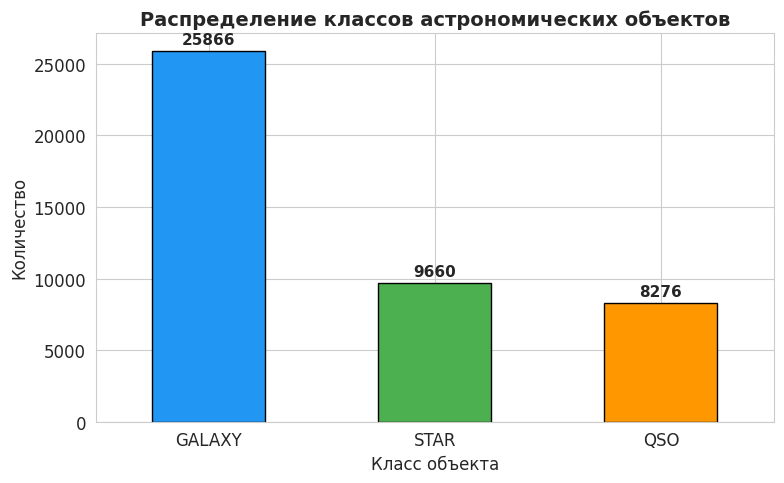

In [5]:
# Распределение целевой переменной
print("=" * 60)
print("РАСПРЕДЕЛЕНИЕ КЛАССОВ")
print("=" * 60)
print(df['class'].value_counts())
print(f"\nДоли классов:")
print(df['class'].value_counts(normalize=True).round(4) * 100)

# Визуализация распределения классов
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
colors = ['#2196F3', '#4CAF50', '#FF9800']
df['class'].value_counts().plot(kind='bar', color=colors, edgecolor='black', ax=ax)
ax.set_title('Распределение классов астрономических объектов', fontsize=14, fontweight='bold')
ax.set_xlabel('Класс объекта', fontsize=12)
ax.set_ylabel('Количество', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
for i, v in enumerate(df['class'].value_counts().values):
    ax.text(i, v + 500, str(v), ha='center', fontweight='bold', fontsize=11)
plt.tight_layout()
plt.show()

## Предварительная обработка датасета

In [6]:
# Проверка пропусков
print("=" * 60)
print("ПРОВЕРКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ")
print("=" * 60)
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "Пропущенных значений нет!")

# Проверка дубликатов
print(f"\nКоличество дубликатов: {df.duplicated().sum()}")

# Удаление дубликатов
df = df.drop_duplicates()
print(f"Размер после удаления дубликатов: {df.shape}")

ПРОВЕРКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
Пропущенных значений нет!

Количество дубликатов: 0
Размер после удаления дубликатов: (43802, 18)


In [7]:
# Удаление нерелевантных столбцов (идентификаторы)
columns_to_drop = ['obj_ID', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'plate', 'MJD', 'fiber_ID']
df_clean = df.drop(columns=columns_to_drop, errors='ignore')

print("Столбцы после очистки:")
print(list(df_clean.columns))
print(f"\nРазмер очищенного датасета: {df_clean.shape}")
df_clean.head()

Столбцы после очистки:
['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'class', 'redshift']

Размер очищенного датасета: (43802, 9)


,alpha,delta,u,g,r,i,z,class,redshift
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY,0.932346
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123


In [8]:
# Кодирование целевой переменной
le = LabelEncoder()
df_clean['class_encoded'] = le.fit_transform(df_clean['class'])

print("Маппинг классов:")
for i, cls in enumerate(le.classes_):
    print(f"  {cls} -> {i}")

# Разделение на признаки и целевую переменную
X = df_clean.drop(columns=['class', 'class_encoded'])
y = df_clean['class_encoded']

print(f"\nРазмер матрицы признаков X: {X.shape}")
print(f"Размер вектора целевой переменной y: {y.shape}")
print(f"\nПризнаки: {list(X.columns)}")

Маппинг классов:
  GALAXY -> 0
  QSO -> 1
  STAR -> 2

Размер матрицы признаков X: (43802, 8)
Размер вектора целевой переменной y: (43802,)

Признаки: ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift']


In [9]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nРазмер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")


Размер обучающей выборки: 30661
Размер тестовой выборки: 13141


In [10]:
# Масштабирование признаков (критически важно для SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Масштабирование выполнено (StandardScaler)!")
print(f"\nСреднее значение признаков (обуч. выборка): {X_train_scaled.mean(axis=0).round(4)}")
print(f"Стд. отклонение признаков (обуч. выборка): {X_train_scaled.std(axis=0).round(4)}")

Масштабирование выполнено (StandardScaler)!

Среднее значение признаков (обуч. выборка): [ 0. -0.  0.  0.  0.  0.  0. -0.]
Стд. отклонение признаков (обуч. выборка): [1. 1. 1. 1. 1. 1. 1. 1.]


## Тепловая карта корреляций (Heatmap)

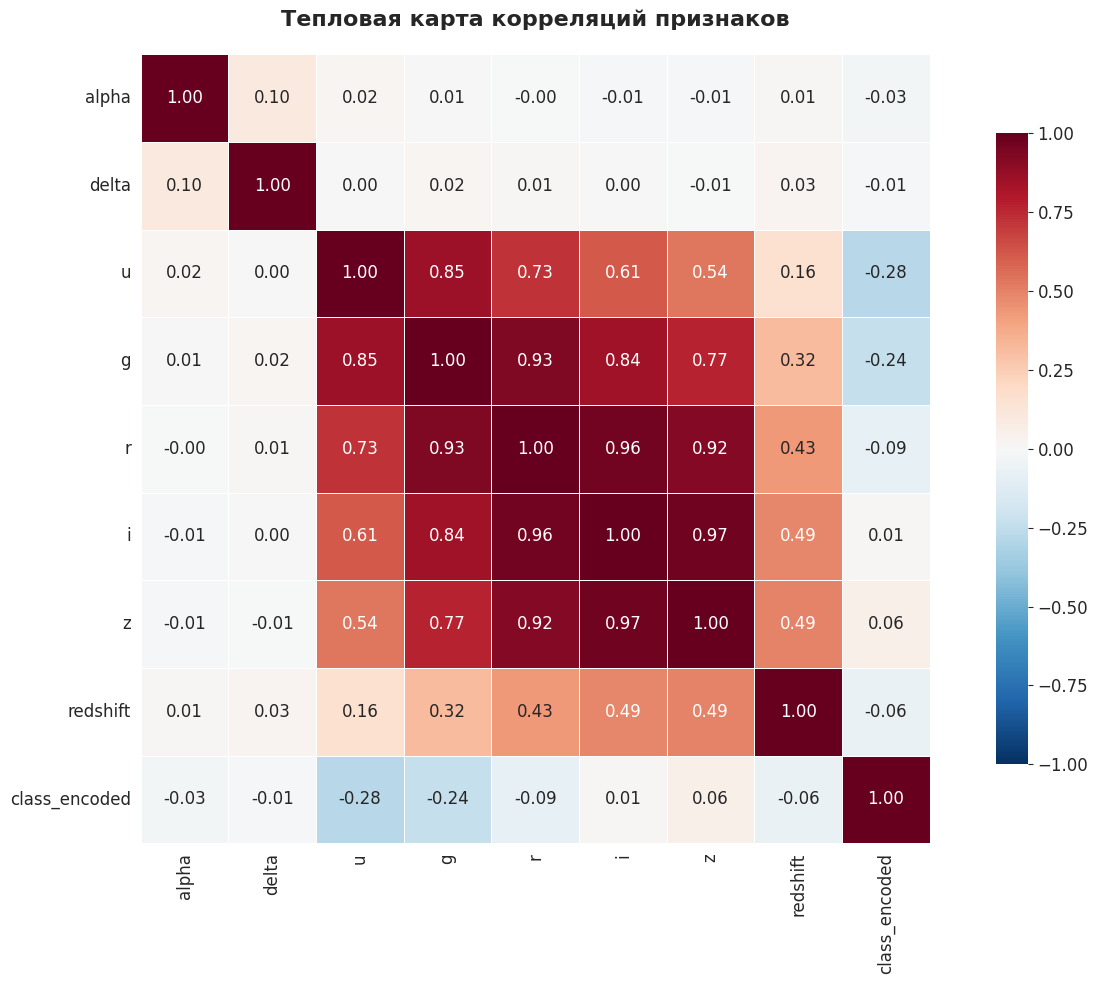

In [11]:
# Тепловая карта корреляций
fig, ax = plt.subplots(figsize=(14, 10))

# Используем очищенные числовые признаки + целевую переменную
corr_df = df_clean.drop(columns=['class']).copy()
correlation_matrix = corr_df.corr()

sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8},
    vmin=-1,
    vmax=1,
    ax=ax
)

ax.set_title('Тепловая карта корреляций признаков', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [12]:
# Корреляции с целевой переменной
print("=" * 60)
print("КОРРЕЛЯЦИЯ ПРИЗНАКОВ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ")
print("=" * 60)
target_corr = correlation_matrix['class_encoded'].drop('class_encoded').sort_values(ascending=False)
print(target_corr.round(4))

КОРРЕЛЯЦИЯ ПРИЗНАКОВ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ
z           0.0622
i           0.0087
delta      -0.0086
alpha      -0.0302
redshift   -0.0627
r          -0.0857
g          -0.2394
u          -0.2803
Name: class_encoded, dtype: float64


## Обучение модели

In [13]:
# Определение сетки гиперпараметров
# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'gamma': ['scale', 'auto', 0.01, 0.1],
#     'kernel': ['rbf', 'poly', 'sigmoid']
# }
param_grid = {
    'C': [100],
    'gamma': ['scale'],
    'kernel': ['rbf']
}

svm_model = SVC(random_state=42, probability=True, verbose=True)

grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=300,
    return_train_score=True
)

grid_search.fit(X_train_scaled, y_train)

print("\n" + "=" * 60)
print("РЕЗУЛЬТАТЫ ПОДБОРА ГИПЕРПАРАМЕТРОВ")
print("=" * 60)
print(f"\nЛучшие параметры: {grid_search.best_params_}")
print(f"Лучшая точность (accuracy) на кросс-валидации: {grid_search.best_score_:.4f}")

best_svm = grid_search.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibSVM]
РЕЗУЛЬТАТЫ ПОДБОРА ГИПЕРПАРАМЕТРОВ

Лучшие параметры: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Лучшая точность (accuracy) на кросс-валидации: 0.9692


## Прогнозы модели

In [14]:
# Прогнозы на тестовой выборке
y_pred = best_svm.predict(X_test_scaled)
y_pred_proba = best_svm.predict_proba(X_test_scaled)

print("=" * 60)
print("ПРОГНОЗЫ МОДЕЛИ")
print("=" * 60)

# Сравнение реальных и предсказанных значений
comparison = pd.DataFrame({
    'Реальный класс': le.inverse_transform(y_test),
    'Предсказанный класс': le.inverse_transform(y_pred),
    'Совпадение': ['✓' if r == p else '✗' for r, p in zip(y_test, y_pred)]
})

print("\nПервые 20 прогнозов:")
print(comparison.head(20).to_string(index=False))

# Общая статистика
correct = (y_pred == y_test).sum()
total = len(y_test)
print(f"\nПравильно классифицировано: {correct} из {total} ({correct/total*100:.2f}%)")
print(f"Неправильно классифицировано: {total - correct} из {total} ({(total-correct)/total*100:.2f}%)")

ПРОГНОЗЫ МОДЕЛИ

Первые 20 прогнозов:
Реальный класс Предсказанный класс Совпадение
          STAR                STAR          ✓
        GALAXY              GALAXY          ✓
          STAR                STAR          ✓
           QSO                 QSO          ✓
           QSO                 QSO          ✓
        GALAXY              GALAXY          ✓
        GALAXY              GALAXY          ✓
        GALAXY              GALAXY          ✓
          STAR                STAR          ✓
        GALAXY                STAR          ✗
        GALAXY              GALAXY          ✓
           QSO                 QSO          ✓
          STAR                STAR          ✓
          STAR                STAR          ✓
           QSO                 QSO          ✓
           QSO                 QSO          ✓
        GALAXY              GALAXY          ✓
          STAR                STAR          ✓
        GALAXY              GALAXY          ✓
        GALAXY              GALAXY        

In [15]:
# Вероятности предсказаний
proba_df = pd.DataFrame(
    y_pred_proba,
    columns=[f'P({cls})' for cls in le.classes_]
)
proba_df['Реальный класс'] = le.inverse_transform(y_test.values)
proba_df['Предсказание'] = le.inverse_transform(y_pred)

print("Вероятности предсказаний (первые 15 объектов):")
proba_df.head(15)

Вероятности предсказаний (первые 15 объектов):


,P(GALAXY),P(QSO),P(STAR),Реальный класс,Предсказание
0,2.438808e-03,0.000015,9.975458e-01,STAR,STAR
1,9.952821e-01,0.004718,8.454458e-08,GALAXY,GALAXY
2,1.581365e-02,0.001165,9.830211e-01,STAR,STAR
3,2.702130e-02,0.972979,1.576968e-07,QSO,QSO
4,6.548011e-03,0.993452,5.043621e-08,QSO,QSO
5,9.871260e-01,0.012874,1.481706e-07,GALAXY,GALAXY
6,9.524007e-01,0.047599,5.004334e-08,GALAXY,GALAXY
7,9.748652e-01,0.025134,5.978408e-07,GALAXY,GALAXY
8,2.563148e-02,0.000904,9.734643e-01,STAR,STAR
9,4.802185e-02,0.000649,9.513294e-01,GALAXY,STAR


## Оценка качества модели

In [16]:
# === ОСНОВНЫЕ МЕТРИКИ ===
print("=" * 60)
print("МЕТРИКИ КАЧЕСТВА КЛАССИФИКАЦИИ")
print("=" * 60)

accuracy = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')

precision_weighted = precision_score(y_test, y_pred, average='weighted')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"\n{'Метрика':<30} {'Macro':<12} {'Weighted':<12}")
print("-" * 54)
print(f"{'Accuracy':<30} {accuracy:<12.4f} {accuracy:<12.4f}")
print(f"{'Precision':<30} {precision_macro:<12.4f} {precision_weighted:<12.4f}")
print(f"{'Recall':<30} {recall_macro:<12.4f} {recall_weighted:<12.4f}")
print(f"{'F1-score':<30} {f1_macro:<12.4f} {f1_weighted:<12.4f}")

print("\n" + "=" * 60)
print("ПОДРОБНЫЙ ОТЧЁТ ПО КЛАССАМ")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=le.classes_))

МЕТРИКИ КАЧЕСТВА КЛАССИФИКАЦИИ

Метрика                        Macro        Weighted    
------------------------------------------------------
Accuracy                       0.9713       0.9713      
Precision                      0.9703       0.9713      
Recall                         0.9641       0.9713      
F1-score                       0.9669       0.9711      

ПОДРОБНЫЙ ОТЧЁТ ПО КЛАССАМ
              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.98      7760
         QSO       0.97      0.92      0.94      2483
        STAR       0.97      1.00      0.98      2898

    accuracy                           0.97     13141
   macro avg       0.97      0.96      0.97     13141
weighted avg       0.97      0.97      0.97     13141



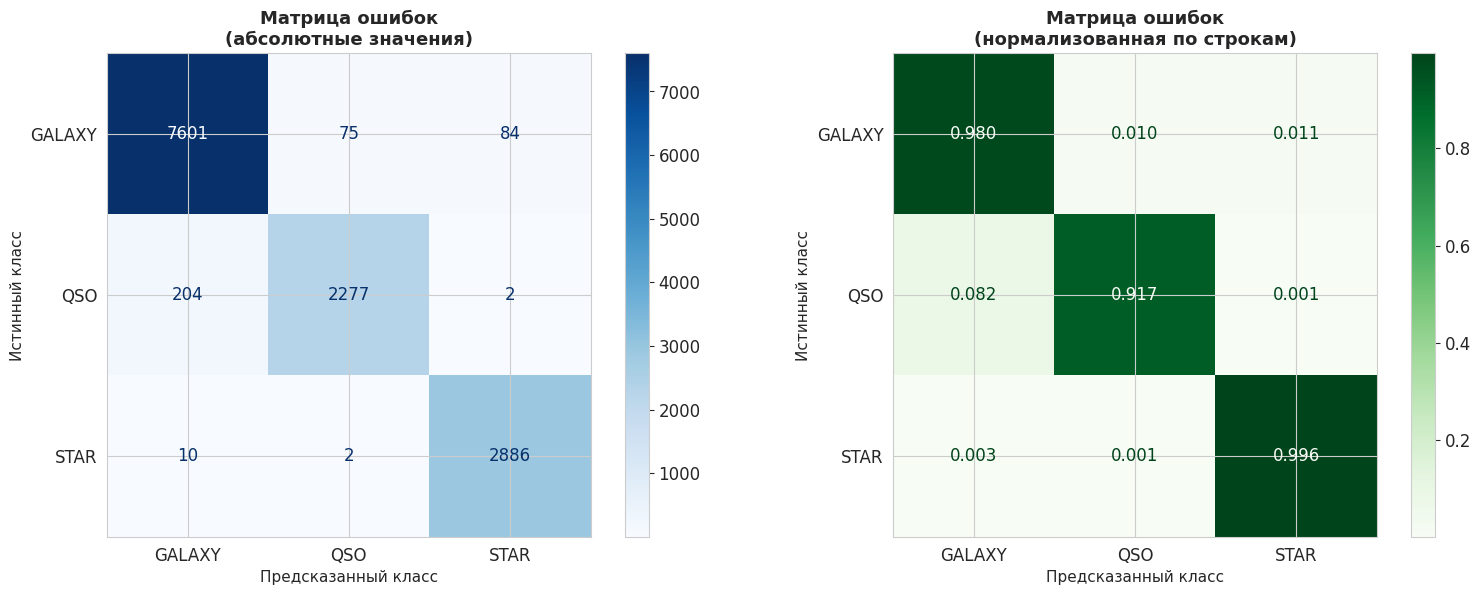

In [17]:
# === 1. МАТРИЦА ОШИБОК ===
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Абсолютные значения
cm = confusion_matrix(y_test, y_pred)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp1.plot(cmap='Blues', ax=axes[0], values_format='d')
axes[0].set_title('Матрица ошибок\n(абсолютные значения)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Предсказанный класс', fontsize=11)
axes[0].set_ylabel('Истинный класс', fontsize=11)

# Нормализованная
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=le.classes_)
disp2.plot(cmap='Greens', ax=axes[1], values_format='.3f')
axes[1].set_title('Матрица ошибок\n(нормализованная по строкам)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Предсказанный класс', fontsize=11)
axes[1].set_ylabel('Истинный класс', fontsize=11)

plt.tight_layout()
plt.show()

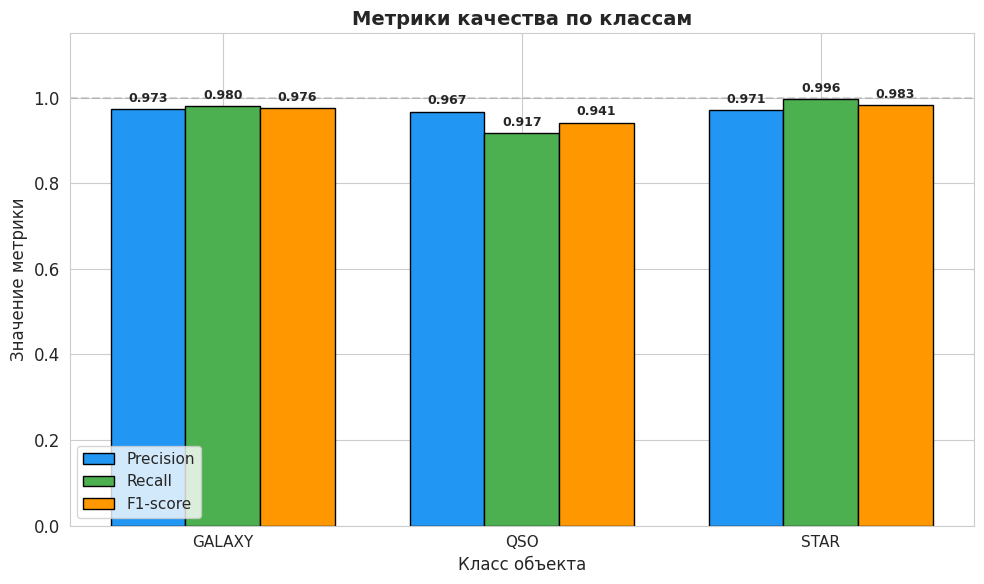

In [18]:
# === 2. СТОЛБЧАТАЯ ДИАГРАММА МЕТРИК ПО КЛАССАМ ===
report_dict = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)

classes = le.classes_
precision_vals = [report_dict[cls]['precision'] for cls in classes]
recall_vals = [report_dict[cls]['recall'] for cls in classes]
f1_vals = [report_dict[cls]['f1-score'] for cls in classes]

x = np.arange(len(classes))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, precision_vals, width, label='Precision', color='#2196F3', edgecolor='black')
bars2 = ax.bar(x, recall_vals, width, label='Recall', color='#4CAF50', edgecolor='black')
bars3 = ax.bar(x + width, f1_vals, width, label='F1-score', color='#FF9800', edgecolor='black')

# Подписи значений
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Класс объекта', fontsize=12)
ax.set_ylabel('Значение метрики', fontsize=12)
ax.set_title('Метрики качества по классам', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(classes, fontsize=11)
ax.legend(fontsize=11)
ax.set_ylim(0, 1.15)
ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

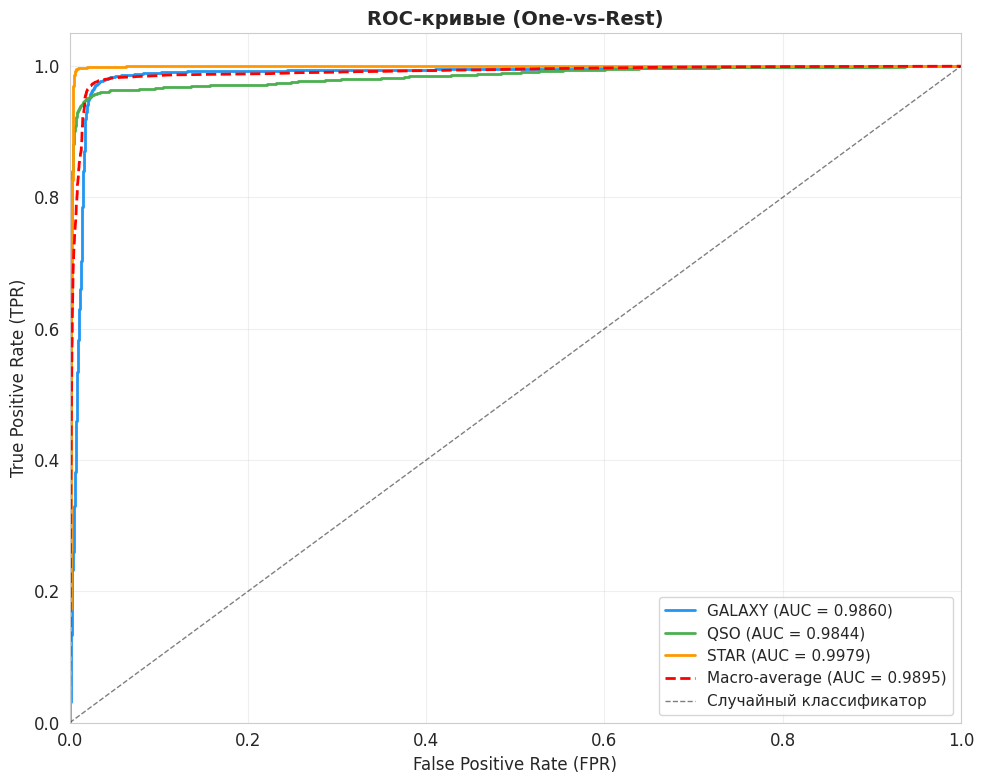

In [19]:
# === 3. ROC-КРИВЫЕ (One-vs-Rest) ===
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = 3

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#2196F3', '#4CAF50', '#FF9800']

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=colors[i], lw=2,
            label=f'{le.classes_[i]} (AUC = {roc_auc:.4f})')

# Средняя ROC (macro)
all_fpr = np.unique(np.concatenate([roc_curve(y_test_bin[:, i], y_pred_proba[:, i])[0] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    mean_tpr += np.interp(all_fpr, fpr, tpr)
mean_tpr /= n_classes
macro_auc = auc(all_fpr, mean_tpr)
ax.plot(all_fpr, mean_tpr, color='red', lw=2, linestyle='--',
        label=f'Macro-average (AUC = {macro_auc:.4f})')

ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5, label='Случайный классификатор')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate (FPR)', fontsize=12)
ax.set_ylabel('True Positive Rate (TPR)', fontsize=12)
ax.set_title('ROC-кривые (One-vs-Rest)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()